In [1]:
#cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

csv_path = "/cluster/home/miolate21/FER_biasmitigation1/results/attributes_jpg.csv" 

print(f"Loading data from: {csv_path}")
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"ERROR: Cannot find CSV file at {csv_path}")
    print("Please ensure the path is correct and the file exists.")
    raise
    
print(f"Rows before filtering: {len(df)}")

if 'status' not in df.columns:
    raise ValueError("CSV file is missing the required 'status' column.")
df = df[df['status'] == 'OK'].copy()
print(f"Rows after filtering status='OK': {len(df)}")
if df.empty:
    raise ValueError("No rows with status 'OK' found in the CSV. Cannot proceed.")

if 'dominant_race' not in df.columns:
    raise ValueError("CSV file is missing the required 'dominant_race' column for renaming.")
df.rename(columns={'dominant_race': 'race'}, inplace=True)

if 'emotion' not in df.columns or 'race' not in df.columns:
    raise ValueError("DataFrame is missing 'emotion' or 'race' column after renaming/filtering.")
df = df[df['emotion'].notnull()]
df = df[df['race'].notnull()]

if 'image_path' not in df.columns:
    raise ValueError("DataFrame is missing the required 'image_path' column.")
df = df[df['image_path'].notnull()]
print(f"Rows after filtering nulls: {len(df)}")
if df.empty:
    raise ValueError("No valid rows remaining after filtering nulls.")

print("Sample image path:", df['image_path'].iloc[0])
if df['image_path'].str.contains(r'\.npy$', regex=True).any():
    print("\nWARNING: Some image paths in the DataFrame still end with .npy!")
    print("This might cause errors later if Cell 4 expects standard image extensions.")
    print("Ensure the loaded CSV was generated correctly and this cell wasn't run with the faulty extension replacement before.\n")

if df['emotion'].nunique() == 0:
    raise ValueError("No unique emotions found after filtering. Cannot create labels.")
emotion_to_idx = {e: i for i, e in enumerate(sorted(df['emotion'].unique()))}
df['label'] = df['emotion'].map(emotion_to_idx)

print("\nDataFrame head after processing:")
print(df.head())

Loading data from: /cluster/home/miolate21/FER_biasmitigation1/results/attributes_jpg.csv
Rows before filtering: 41478
Rows after filtering status='OK': 40649
Rows after filtering nulls: 40649
Sample image path: /cluster/home/miolate21/FER_biasmitigation1/data/fer2013/train/happy/Training_6312930.jpg

DataFrame head after processing:
                                          image_path emotion   race status  \
0  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white     OK   
1  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white     OK   
2  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white     OK   
3  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white     OK   
4  /cluster/home/miolate21/FER_biasmitigation1/da...   happy  white     OK   

   label  
0      3  
1      3  
2      3  
3      3  
4      3  


Text(0.5, 1.0, 'Emotion by Race Distribution')

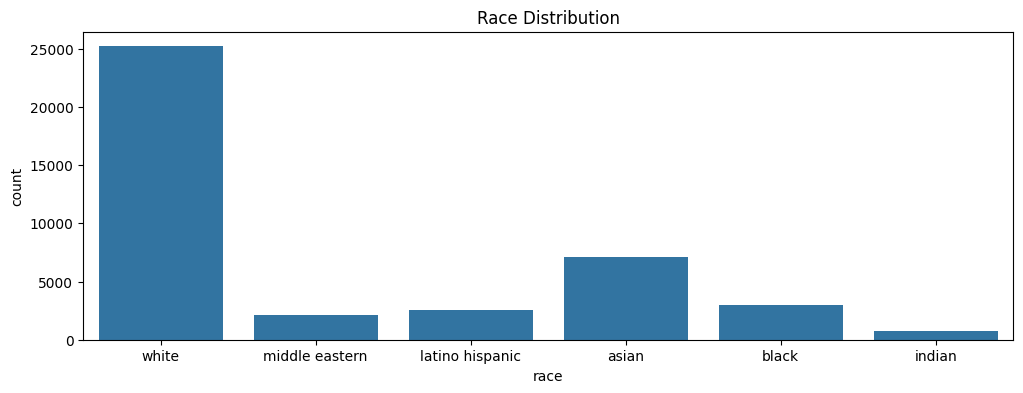

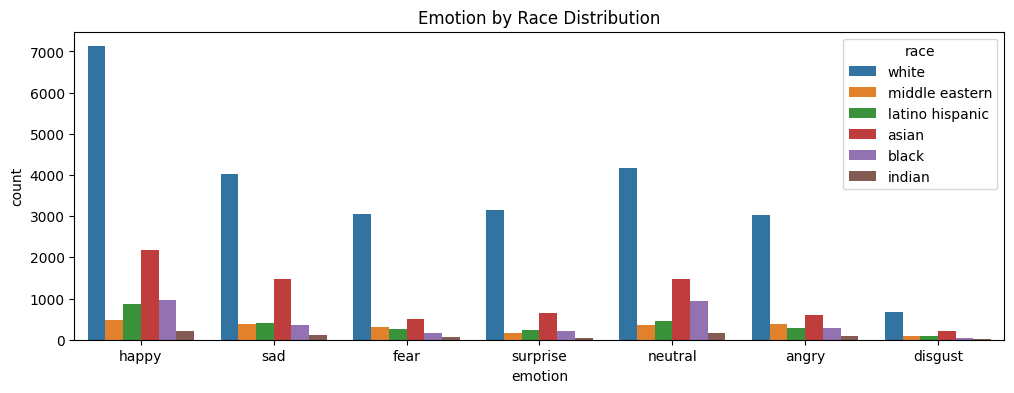

In [3]:
#cell 2

import seaborn as sns

plt.figure(figsize=(12,4))
sns.countplot(x='race', data=df)
plt.title('Race Distribution')

plt.figure(figsize=(12,4))
sns.countplot(x='emotion', data=df, hue='race')
plt.title('Emotion by Race Distribution')


In [4]:
#cell 3

race_counts = df['race'].value_counts()
total = len(df)
race_weights = {race: total / count for race, count in race_counts.items()}

df['sample_weight'] = df['race'].map(race_weights)


In [5]:
# cell 4 
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
], name="data_augmentation")

@tf.function
def load_and_prep_image(image_path, label_int, weight_f, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    if augment:
        img = data_augmentation(img, training=True)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label_int, weight_f

def build_weighted_dataset(df_subset, training=True):
    ds = tf.data.Dataset.from_tensor_slices((
        df_subset["image_path"].values,
        df_subset["label"].values.astype("int32"),
        df_subset["sample_weight"].values.astype("float32")
    ))
    if training:
        buffer_size = min(len(df_subset), 10000)
        ds = ds.shuffle(buffer_size=buffer_size, seed=42, reshuffle_each_iteration=True)
    ds = ds.map(
        lambda path, label, weight: load_and_prep_image(path, label, weight, augment=training),
        num_parallel_calls=AUTOTUNE
    )
    return ds.batch(BATCH, drop_remainder=False).prefetch(AUTOTUNE)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

train_ds = build_weighted_dataset(train_df, training=True)
val_ds = build_weighted_dataset(val_df, training=False)

val_ds = val_ds.map(lambda x, y, w: (x, y))

print("Train Dataset Spec:", train_ds.element_spec)
print("Validation Dataset Spec:", val_ds.element_spec)

Training samples: 32519
Validation samples: 8130
Train Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Validation Dataset Spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [6]:
# cell 5 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

if 'emotion_to_idx' not in locals() or not emotion_to_idx:
    raise NameError("Variable 'emotion_to_idx' not defined or empty.")
num_classes = len(emotion_to_idx)
print(f"Number of output classes (emotions): {num_classes}")

if 'IMG_SIZE' not in locals():
    raise NameError("Variable 'IMG_SIZE' not defined.")
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

model_path = "models/resnet50_baseline_224.keras"  
print(f"Loading fine-tuned model from: {model_path}")
model = tf.keras.models.load_model(model_path)

freeze_until_layer = 50
print(f"Freezing base_model layers up to index {freeze_until_layer}...")
for layer in base_model.layers[:freeze_until_layer]:
    layer.trainable = False
for layer in base_model.layers[freeze_until_layer:]:
    layer.trainable = True
print(f"Set layers after index {freeze_until_layer} to trainable.")

x = base_model.output
x = GlobalAveragePooling2D()(x)
dropout_rate = 0.5
print(f"Adding Dropout layer with rate {dropout_rate}")
x = Dropout(dropout_rate)(x)
output = Dense(num_classes, activation='softmax', name='emotion_output')(x)
model = Model(inputs=base_model.input, outputs=output)

initial_learning_rate = 1e-4
print(f"Compiling model with Adam optimizer (LR={initial_learning_rate})...")
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

print("Model summary:")
model.summary()

Number of output classes (emotions): 7
Loading ResNet50 base model with ImageNet weights...
Freezing base_model layers up to index 50...
Set layers after index 50 to trainable.
Adding Dropout layer with rate 0.5
Compiling model with Adam optimizer (LR=0.0001)...
Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 22,941,447 (87.51 MB)

 Non-trainable params: 660,608 (2.52 MB)

In [7]:
# cell 6
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    ModelCheckpoint("models/resnet50_raceweighted_finetuned50FL.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30, 
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


I0000 00:00:1745612218.889420  618042 service.cc:146] XLA service 0x7f12a0002060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745612218.889462  618042 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6


   1/1017 ━━━━━━━━━━━━━━━━━━━━ 7:59:20 28s/step - accuracy: 0.2500 - loss: 10.8512

I0000 00:00:1745612234.477698  618042 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2488 - loss: 11.4259 
Epoch 1: val_accuracy improved from -inf to 0.27245, saving model to models/resnet50_raceweighted_finetuned50FL.keras
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 114s 84ms/step - accuracy: 0.2488 - loss: 11.4254 - val_accuracy: 0.2724 - val_loss: 2.3469 - learning_rate: 1.0000e-04
Epoch 2/30
1016/1017 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3238 - loss: 10.1736 
Epoch 2: val_accuracy improved from 0.27245 to 0.43050, saving model to models/resnet50_raceweighted_finetuned50FL.keras
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - accuracy: 0.3239 - loss: 10.1734 - val_accuracy: 0.4305 - val_loss: 1.5185 - learning_rate: 1.0000e-04
Epoch 3/30
1016/1017 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3504 - loss: 9.8301  
Epoch 3: val_accuracy improved from 0.43050 to 0.48253, saving model to models/resnet50_raceweighted_finetuned50FL.keras
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 67s 66ms/step - accuracy: 0.3504 - loss: 9.830

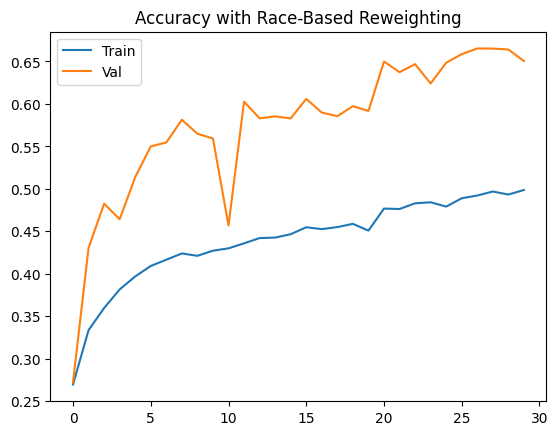

In [15]:
#cell 7
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend()
plt.title("Accuracy with Race-Based Reweighting")
plt.show()


In [16]:
#cell 8

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH = 32

model_path = "models/resnet50_raceweighted_finetuned50FL.keras"
print(f"Loading saved model from: {model_path}")
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    raise SystemExit("Could not load the trained model.")

if 'val_df' not in locals():
    print("Validation DataFrame 'val_df' not found. Re-running train_test_split from Cell 4...")
    from sklearn.model_selection import train_test_split
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df['label'],
        random_state=42
    )
    print(f"Validation samples: {len(val_df)}")

required_cols = ['image_path', 'label', 'race']
if not all(col in val_df.columns for col in required_cols):
    raise ValueError(f"Validation DataFrame 'val_df' is missing one of required columns: {required_cols}")

@tf.function
def load_and_prep_image_eval(image_path, label_int):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label_int

print("Preparation for evaluation complete.")

Loading saved model from: models/resnet50_raceweighted_finetuned50FL.keras
Model loaded successfully.
Preparation for evaluation complete.



--- Overall Validation Performance ---
Overall Validation Loss: 0.9454
Overall Validation Accuracy: 0.6652 (66.52%)

--- Per-Race Validation Performance ---
Evaluating for race: asian
  Number of samples: 1469
  Accuracy for asian: 0.6835 (68.35%)
Evaluating for race: black
  Number of samples: 571
  Accuracy for black: 0.7391 (73.91%)
Evaluating for race: indian
  Number of samples: 156
  Accuracy for indian: 0.6667 (66.67%)
Evaluating for race: latino hispanic
  Number of samples: 533
  Accuracy for latino hispanic: 0.6942 (69.42%)
Evaluating for race: middle eastern
  Number of samples: 423
  Accuracy for middle eastern: 0.6265 (62.65%)
Evaluating for race: white
  Number of samples: 4978
  Accuracy for white: 0.6515 (65.15%)

--- Summary of Per-Race Accuracies ---
           Race  Validation Accuracy
          black             0.739054
latino hispanic             0.694184
          asian             0.683458
         indian             0.666667
          white             0.65146

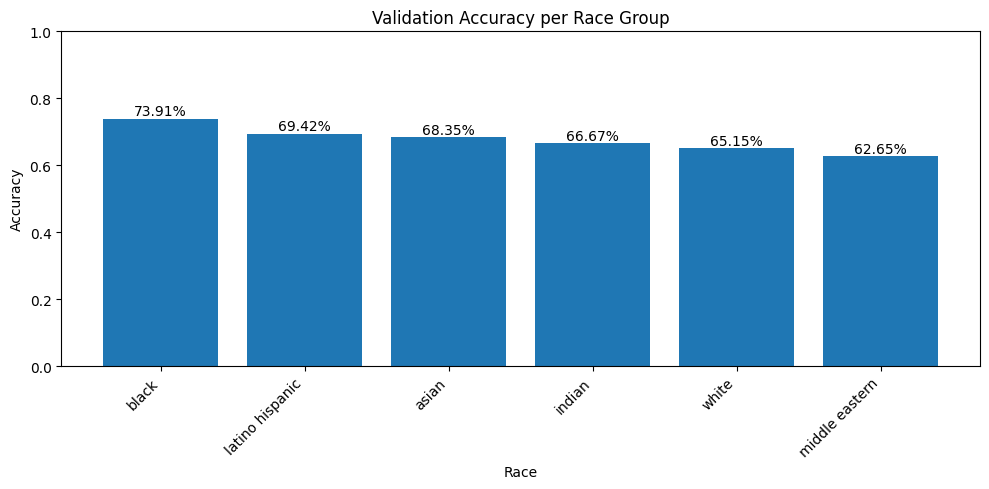

In [17]:
#cell 9
print("\n--- Overall Validation Performance ---")
overall_val_ds = tf.data.Dataset.from_tensor_slices((
    val_df["image_path"].values,
    val_df["label"].values.astype("int32")
))
overall_val_ds = overall_val_ds.map(load_and_prep_image_eval, num_parallel_calls=tf.data.AUTOTUNE)
overall_val_ds = overall_val_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
overall_loss, overall_acc = model.evaluate(overall_val_ds, verbose=0)
print(f"Overall Validation Loss: {overall_loss:.4f}")
print(f"Overall Validation Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")

print("\n--- Per-Race Validation Performance ---")
race_accuracies = {}
unique_races = sorted(val_df['race'].unique())

for race in unique_races:
    print(f"Evaluating for race: {race}")
    race_df = val_df[val_df['race'] == race]
    if race_df.empty:
        print(f"  No validation samples found for race '{race}'. Skipping.")
        race_accuracies[race] = np.nan
        continue
    print(f"  Number of samples: {len(race_df)}")
    race_ds = tf.data.Dataset.from_tensor_slices((
        race_df["image_path"].values,
        race_df["label"].values.astype("int32")
    ))
    race_ds = race_ds.map(load_and_prep_image_eval, num_parallel_calls=tf.data.AUTOTUNE)
    race_ds = race_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    try:
        loss, acc = model.evaluate(race_ds, verbose=0)
        print(f"  Accuracy for {race}: {acc:.4f} ({acc*100:.2f}%)")
        race_accuracies[race] = acc
    except tf.errors.InvalidArgumentError as e:
        print(f"  Skipping evaluation for {race} due to error: {e}")
        race_accuracies[race] = np.nan
    except Exception as e:
        print(f"  An unexpected error occurred during evaluation for {race}: {e}")
        race_accuracies[race] = np.nan

print("\n--- Summary of Per-Race Accuracies ---")
acc_df = pd.DataFrame(race_accuracies.items(), columns=['Race', 'Validation Accuracy'])
acc_df = acc_df.sort_values(by='Validation Accuracy', ascending=False)
print(acc_df.to_string(index=False))

if not acc_df.empty:
    plt.figure(figsize=(10, 5))
    plt.bar(acc_df['Race'], acc_df['Validation Accuracy'])
    plt.title('Validation Accuracy per Race Group')
    plt.xlabel('Race')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(acc_df['Validation Accuracy']):
        if not pd.isna(value):
            plt.text(index, value + 0.01, f"{value:.2%}", ha='center')
    plt.tight_layout()
    plt.show()

In [18]:
# cell 10
import numpy as np
import tensorflow as tf

print("Preparing validation dataset for predictions...")

try:
    overall_val_ds_pred = tf.data.Dataset.from_tensor_slices((
        val_df["image_path"].values,
        val_df["label"].values.astype("int32")
    ))
    overall_val_ds_pred = overall_val_ds_pred.map(load_and_prep_image_eval, num_parallel_calls=AUTOTUNE)
    overall_val_ds_pred = overall_val_ds_pred.batch(BATCH).prefetch(AUTOTUNE)
    print("Dataset prepared.")
except NameError as e:
     print(f"Error: A required variable/function seems missing (e.g., val_df, load_and_prep_image_eval, AUTOTUNE, BATCH). Details: {e}")
     raise
except Exception as e:
     print(f"An error occurred during validation dataset preparation: {e}")
     raise


print("Generating predictions for the validation set...")
try:
    y_pred_proba = model.predict(overall_val_ds_pred)
    y_pred = np.argmax(y_pred_proba, axis=1)
    print(f"Predictions generated. Shape: {y_pred.shape}")
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
    raise

y_true = val_df['label'].values
print(f"True labels extracted. Shape: {y_true.shape}")

if len(y_true) != len(y_pred):
    print("WARNING: Mismatch between number of true labels and predictions!")

print("Prediction and true label arrays ready.")

Preparing validation dataset for predictions...
Dataset prepared.
Generating predictions for the validation set...
255/255 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
Predictions generated. Shape: (8130,)
True labels extracted. Shape: (8130,)
Prediction and true label arrays ready.


In [19]:
# cell 11

from sklearn.metrics import confusion_matrix, recall_score, precision_score
import numpy as np
import pandas as pd

def calculate_per_group_metrics(df, y_true, y_pred, group_col='race', label_col='label'):
    results = {}
    unique_groups = sorted(df[group_col].unique())
    num_classes = max(y_true.max(), y_pred.max()) + 1
    class_labels = list(range(num_classes))

    if len(df) != len(y_true) or len(df) != len(y_pred):
         raise ValueError(f"Length mismatch: df={len(df)}, y_true={len(y_true)}, y_pred={len(y_pred)}")

    for group in unique_groups:
        idx = (df[group_col] == group)
        y_true_group = y_true[idx]
        y_pred_group = y_pred[idx]

        if len(y_true_group) == 0:
            continue

        cm = confusion_matrix(y_true_group, y_pred_group, labels=class_labels)
        recall = recall_score(y_true_group, y_pred_group, average=None, labels=class_labels, zero_division=0)
        precision = precision_score(y_true_group, y_pred_group, average=None, labels=class_labels, zero_division=0)
        support = np.sum(cm, axis=1)
        accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0

        results[group] = {
            'cm': cm,
            'recall_per_class': recall,
            'precision_per_class': precision,
            'support_per_class': support,
            'accuracy': accuracy
        }
    return results

def calculate_fairness_gaps(group_metrics):
    if not group_metrics:
        return {"max_accuracy_gap": np.nan, "min_recall_gap": np.nan}

    accuracies = [m['accuracy'] for m in group_metrics.values() if 'accuracy' in m]
    min_recalls_per_group = []
    for group, metrics in group_metrics.items():
         if 'recall_per_class' in metrics and len(metrics['recall_per_class']) > 0:
              min_recall_for_group = np.min(metrics['recall_per_class'])
              min_recalls_per_group.append(min_recall_for_group)

    max_acc_gap = np.max(accuracies) - np.min(accuracies) if accuracies else np.nan
    min_recall_gap = np.max(min_recalls_per_group) - np.min(min_recalls_per_group) if min_recalls_per_group else np.nan

    return {
        "max_accuracy_gap": max_acc_gap,
        "min_recall_gap": min_recall_gap
    }

print("Metric functions defined.")

Metric functions defined.



DETAILED FAIRNESS ANALYSIS

Overall Validation Accuracy: 0.6769
Maximum Accuracy Gap Across Races: 0.1126
Minimum Recall Gap Across Races: 0.4167
------------------------------------------------------------

--- Metrics for Race: asian ---
  Overall Accuracy: 0.6835

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.544      0.569      136
disgust    0.244      0.500       45
fear       0.113      0.387      106
happy      0.903      0.828      442
neutral    0.660      0.608      291
sad        0.672      0.698      317
surprise   0.780      0.563      132


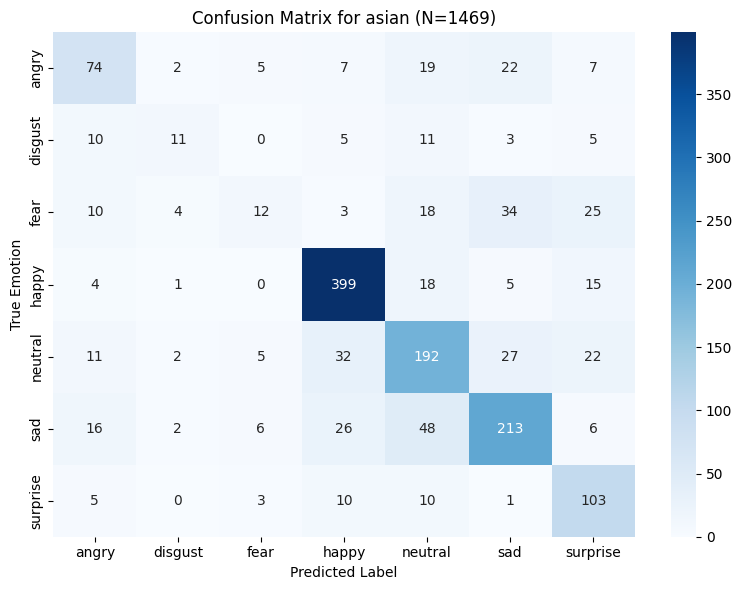


--- Metrics for Race: black ---
  Overall Accuracy: 0.7391

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.556      0.652       54
disgust    0.000      0.000        9
fear       0.103      0.500       39
happy      0.948      0.853      172
neutral    0.863      0.738      183
sad        0.380      0.551       71
surprise   0.930      0.667       43


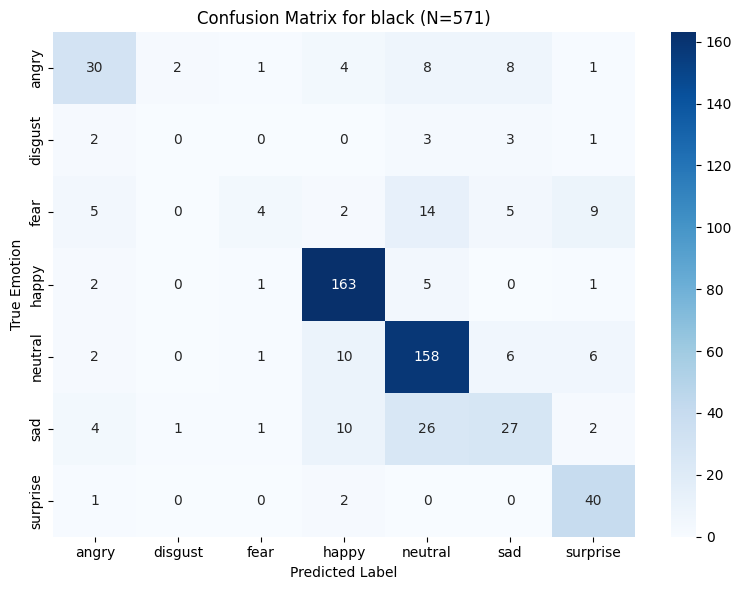


--- Metrics for Race: indian ---
  Overall Accuracy: 0.6667

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.632      0.522       19
disgust    0.500      0.500        2
fear       0.417      0.833       12
happy      0.865      0.789       52
neutral    0.579      0.611       38
sad        0.591      0.565       22
surprise   0.545      0.667       11


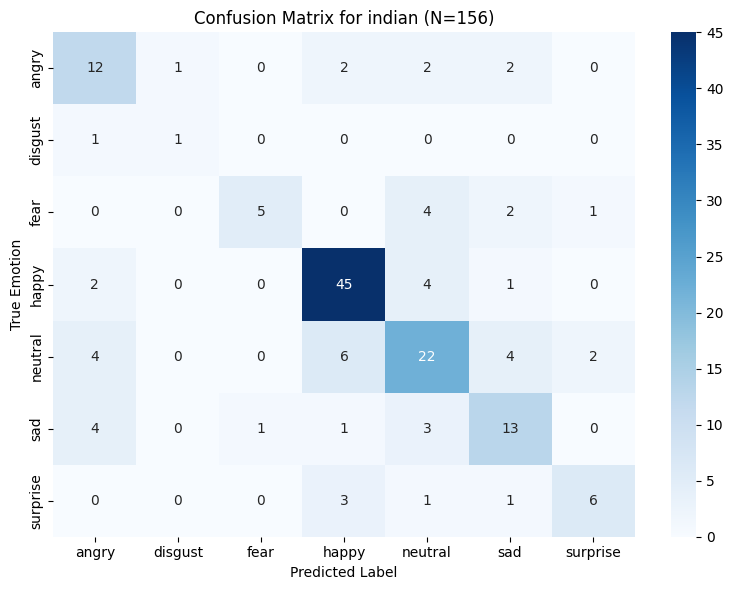


--- Metrics for Race: latino hispanic ---
  Overall Accuracy: 0.6942

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.561      0.533       57
disgust    0.318      0.700       22
fear       0.308      0.762       52
happy      0.925      0.843      186
neutral    0.741      0.583       81
sad        0.530      0.629       83
surprise   0.750      0.600       52


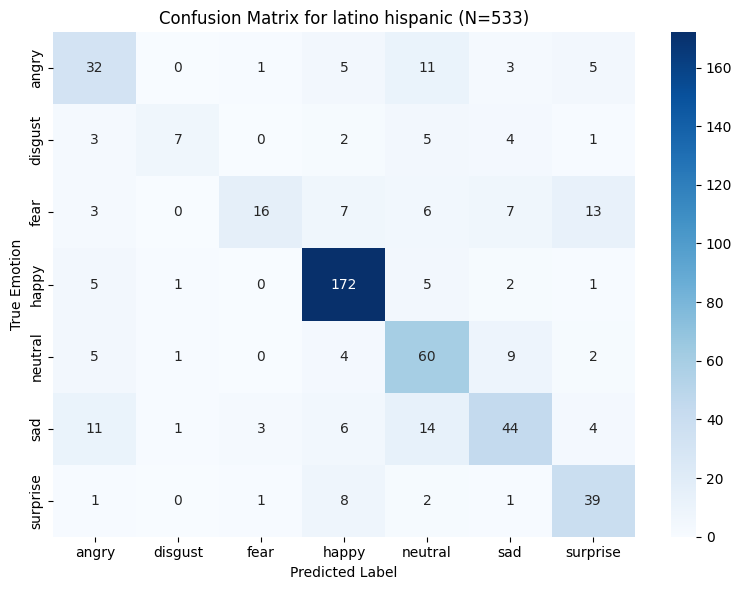


--- Metrics for Race: middle eastern ---
  Overall Accuracy: 0.6265

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.625      0.543       80
disgust    0.381      0.727       21
fear       0.364      0.706       66
happy      0.918      0.804       85
neutral    0.652      0.536       69
sad        0.534      0.534       73
surprise   0.724      0.656       29


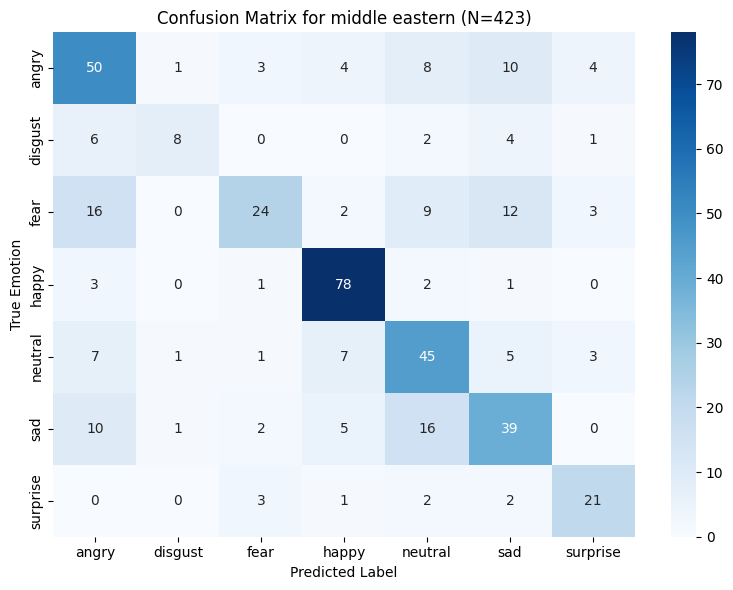


--- Metrics for Race: white ---
  Overall Accuracy: 0.6515

  Per-Emotion Metrics:
          Recall  Precision  Support
angry      0.599      0.516      584
disgust    0.343      0.575      134
fear       0.276      0.560      594
happy      0.896      0.832     1418
neutral    0.628      0.551      847
sad        0.499      0.548      780
surprise   0.792      0.680      621


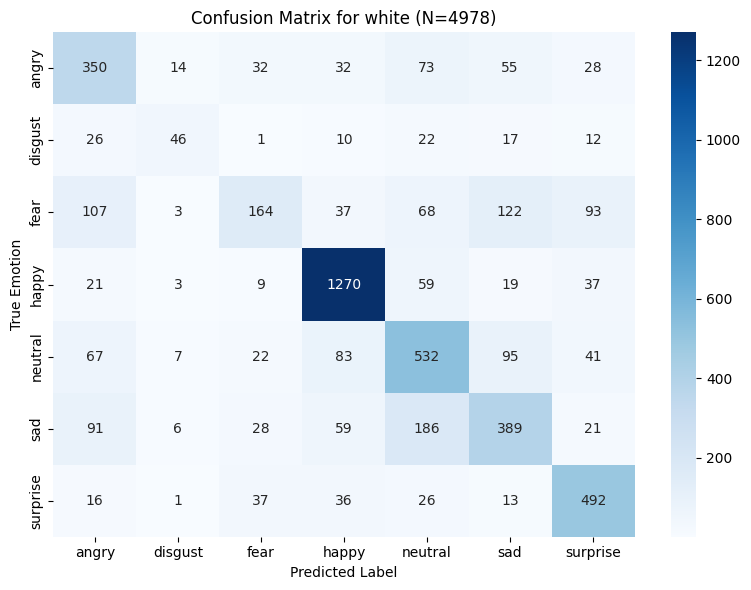


Fairness Analysis Complete


In [26]:
#cell 12
import matplotlib.pyplot as plt
import seaborn as sns

if 'val_df' not in locals() or 'y_true' not in locals() or 'y_pred' not in locals():
     raise NameError("Required variables (val_df, y_true, y_pred) not found. Ensure previous cells ran.")
if 'idx_to_emotion' not in locals() or not idx_to_emotion:
     idx_to_emotion = {v: k for k, v in emotion_to_idx.items()}
emotion_labels = [idx_to_emotion[i] for i in sorted(idx_to_emotion.keys())]

per_group_results = calculate_per_group_metrics(val_df, y_true, y_pred, group_col='race')

fairness_gaps = calculate_fairness_gaps(per_group_results)

print("\n" + "="*60)
print("DETAILED FAIRNESS ANALYSIS")
print("="*60)

print(f"\nOverall Validation Accuracy: {np.mean([m['accuracy'] for m in per_group_results.values()]):.4f}")
print(f"Maximum Accuracy Gap Across Races: {fairness_gaps['max_accuracy_gap']:.4f}")
print(f"Minimum Recall Gap Across Races: {fairness_gaps['min_recall_gap']:.4f}")
print("-" * 60)

for race, metrics in per_group_results.items():
    print(f"\n--- Metrics for Race: {race} ---")
    print(f"  Overall Accuracy: {metrics['accuracy']:.4f}")
    print("\n  Per-Emotion Metrics:")
    metrics_df = pd.DataFrame({
        'Recall': metrics['recall_per_class'],
        'Precision': metrics['precision_per_class'],
        'Support': metrics['support_per_class']
    }, index=emotion_labels)
    print(metrics_df[metrics_df['Support'] > 0].round(3))

    cm = metrics['cm']
    cm_df = pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {race} (N={np.sum(cm)})')
    plt.ylabel('True Emotion')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("Fairness Analysis Complete")
print("="*60)

              precision    recall  f1-score   support

       angry       0.53      0.59      0.56       930
     disgust       0.57      0.31      0.40       233
        fear       0.57      0.26      0.36       869
       happy       0.83      0.90      0.87      2355
     neutral       0.59      0.67      0.63      1509
         sad       0.59      0.54      0.56      1346
    surprise       0.65      0.79      0.71       888

    accuracy                           0.67      8130
   macro avg       0.62      0.58      0.58      8130
weighted avg       0.66      0.67      0.65      8130



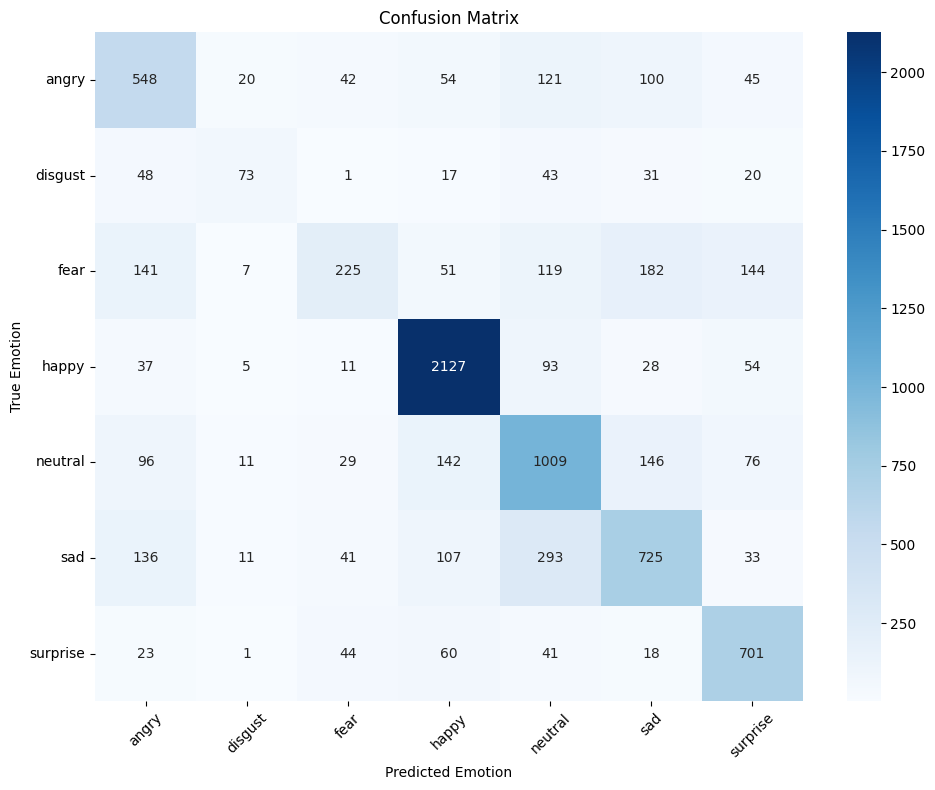

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for images, labels in val_ds.unbatch().batch(32):  
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print(classification_report(y_true, y_pred, target_names=emotion_to_idx.keys()))



emotion_labels = list(emotion_to_idx.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()